# **Import libraries**

In [9]:
import os
import random
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import mode
from sklearn.linear_model import LogisticRegression

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
!unzip "/content/gdrive/MyDrive/RiceLeafDiseaseImages.zip"

Archive:  /content/gdrive/MyDrive/RiceLeafDiseaseImages.zip
replace RiceLeafDiseaseImages/Bacterialblight/BACTERAILBLIGHT3_001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: RiceLeafDiseaseImages/Bacterialblight/BACTERAILBLIGHT3_001.jpg  
  inflating: RiceLeafDiseaseImages/Bacterialblight/BACTERAILBLIGHT3_002.jpg  
  inflating: RiceLeafDiseaseImages/Bacterialblight/BACTERAILBLIGHT3_003.jpg  
  inflating: RiceLeafDiseaseImages/Bacterialblight/BACTERAILBLIGHT3_004.jpg  
  inflating: RiceLeafDiseaseImages/Bacterialblight/BACTERAILBLIGHT3_005.jpg  
  inflating: RiceLeafDiseaseImages/Bacterialblight/BACTERAILBLIGHT3_006.jpg  
  inflating: RiceLeafDiseaseImages/Bacterialblight/BACTERAILBLIGHT3_007.jpg  
  inflating: RiceLeafDiseaseImages/Bacterialblight/BACTERAILBLIGHT3_008.jpg  
  inflating: RiceLeafDiseaseImages/Bacterialblight/BACTERAILBLIGHT3_009.jpg  
  inflating: RiceLeafDiseaseImages/Bacterialblight/BACTERAILBLIGHT3_010.jpg  
  inflating: RiceLeafDiseaseImages/Bacterialblig

# **Split data into 3 sets**

In [12]:
def load_and_resize_image(file_path, target_shape=(128, 128)):
    image = cv2.imread(file_path)
    resized_image = cv2.resize(image, target_shape)
    return resized_image

In [13]:
def load_image_class_by_directory(image_dir):
    image_files = os.listdir(image_dir)
    images = []
    for file in image_files:
        if file.endswith('.jpg') or file.endswith('.JPG') or file.endswith('.png'):
            image_path = os.path.join(image_dir, file)
            resized_image = load_and_resize_image(image_path)
            images.append(resized_image)

    print(f"Num of images: {len(images)}")
    print(f"Single image shape before flattening: {images[0].shape}")
    return images

In [14]:
def display_images(images, num_images_to_display = 6):
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 5))
    for i in range(num_images_to_display):
        image = images[i].astype(np.uint8)
        axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[i].axis('off')
    plt.show()

Num of images: 1604
Single image shape before flattening: (128, 128, 3)


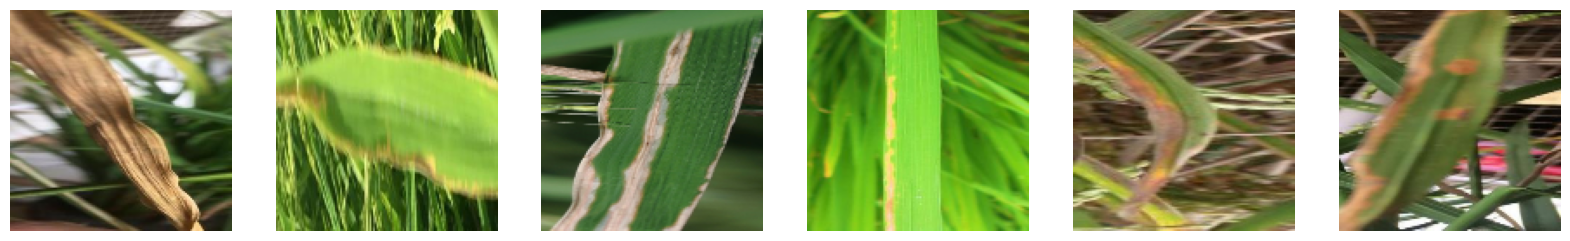

In [15]:
image_dir = "/content/RiceLeafDiseaseImages/Bacterialblight"
images_Bacterialblight = load_image_class_by_directory(image_dir)
display_images(images_Bacterialblight)

Num of images: 603
Single image shape before flattening: (128, 128, 3)


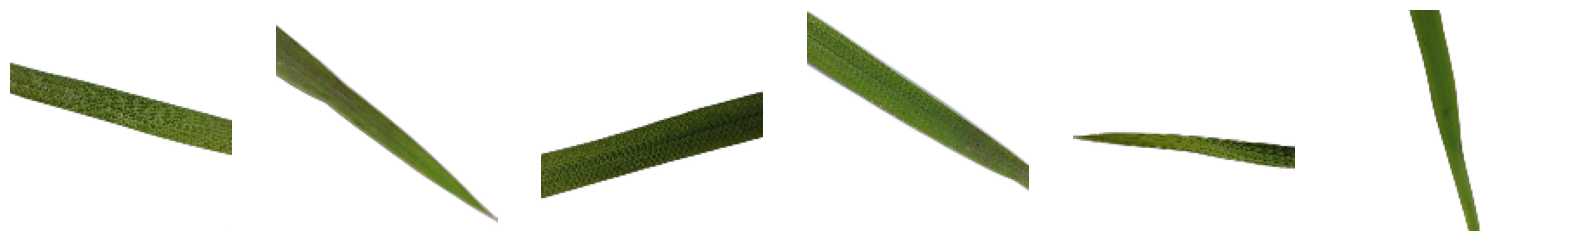

In [16]:
image_dir = "/content/RiceLeafDiseaseImages/Healthy"
images_Healthy = load_image_class_by_directory(image_dir)
display_images(images_Healthy)

Num of images: 1620
Single image shape before flattening: (128, 128, 3)


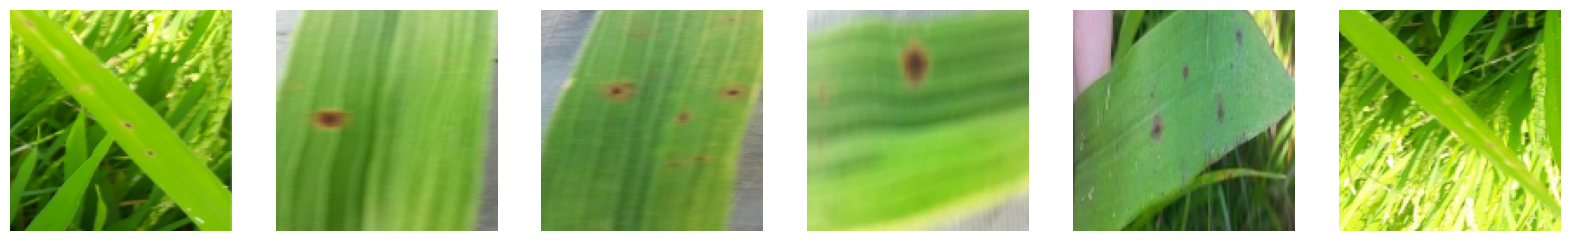

In [17]:
image_dir = "/content/RiceLeafDiseaseImages/Brownspot"
images_Brownspot = load_image_class_by_directory(image_dir)
display_images(images_Brownspot)

Num of images: 500
Single image shape before flattening: (128, 128, 3)


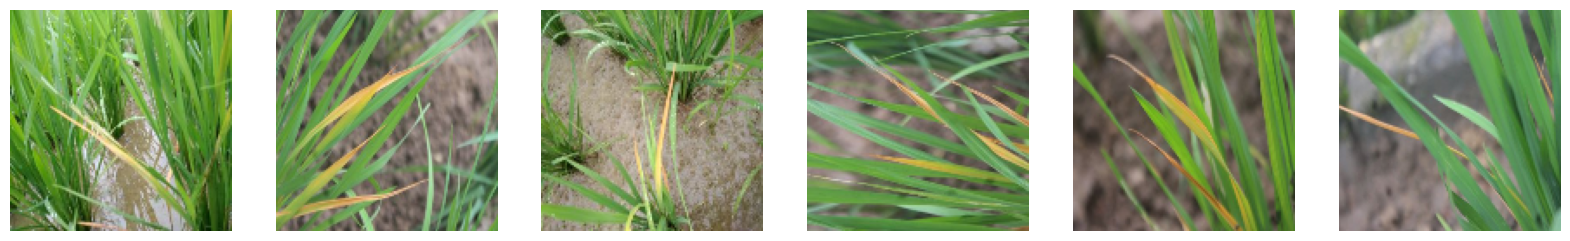

In [18]:
image_dir = "/content/RiceLeafDiseaseImages/Tungro"
images_Tungro = load_image_class_by_directory(image_dir)
display_images(images_Tungro)

In [19]:
source_dir = "/content/RiceLeafDiseaseImages"

train_dir = os.path.join(source_dir, "train")
val_dir = os.path.join(source_dir, "validation")
test_dir = os.path.join(source_dir, "test")

In [20]:
train_percentage = 0.6
val_percentage = 0.3
test_percentage = 0.1

In [21]:
def create_class_directories(class_name, train_dir, val_dir, test_dir):
    dest_class_train_path = os.path.join(train_dir, class_name)
    dest_class_val_path = os.path.join(val_dir, class_name)
    dest_class_test_path = os.path.join(test_dir, class_name)
    os.makedirs(dest_class_train_path, exist_ok=True)
    os.makedirs(dest_class_val_path, exist_ok=True)
    os.makedirs(dest_class_test_path, exist_ok=True)

In [22]:
def create_class_directories_for_all_classes(classes, train_dir, val_dir, test_dir):
    for class_name in classes:
        create_class_directories(class_name, train_dir, val_dir, test_dir)

In [23]:
def move_images_for_class(class_name, source_dir, train_dir, val_dir, test_dir):
    class_path = os.path.join(source_dir, class_name)
    dest_class_train_path = os.path.join(train_dir, class_name)
    dest_class_val_path = os.path.join(val_dir, class_name)
    dest_class_test_path = os.path.join(test_dir, class_name)

    images = os.listdir(class_path)
    total_images = len(images)
    num_train = int(total_images * train_percentage)
    num_val = int(total_images * val_percentage)
    num_test = total_images - num_train - num_val

    random.shuffle(images)

    for i, file_name in enumerate(images):
        if i < num_train:
            shutil.move(os.path.join(class_path, file_name), dest_class_train_path)
        elif i < num_train + num_val:
            shutil.move(os.path.join(class_path, file_name), dest_class_val_path)
        else:
            shutil.move(os.path.join(class_path, file_name), dest_class_test_path)

def move_images_for_all_classes(classes, source_dir, train_dir, val_dir, test_dir):
    for class_name in classes:
        move_images_for_class(class_name, source_dir, train_dir, val_dir, test_dir)

classes = os.listdir(source_dir)

create_class_directories_for_all_classes(classes, train_dir, val_dir, test_dir)

move_images_for_all_classes(classes, source_dir, train_dir, val_dir, test_dir)

In [24]:
train_dir = '/content/RiceLeafDiseaseImages/train'
test_dir = '/content/RiceLeafDiseaseImages/test'
val_dir = '/content/RiceLeafDiseaseImages/validation'
batch_size = 32

# **Data Pre-processing**

In [25]:
def apply_eclahe(image):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    if gray.dtype != 'uint8':
        gray = (gray * 255).astype('uint8')

    eclahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return eclahe.apply(gray)


def kgdc_segmentation(image):
    segmented_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)[1]
    return segmented_image

In [26]:
def extract_features_batch(images):
    images_resized = [cv2.resize(img, (224, 224)) for img in images]
    images_resized = np.array(images_resized) / 255.0

    features = base_model.predict(images_resized)
    return features.reshape(features.shape[0], -1)

def optimize_features(features):
    optimized_features = features
    return optimized_features

In [27]:
def process_dataset(data_dir):
    X, y = [], []
    image_batch = []
    label_batch = []

    for label in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label)
        for image_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_file)
            image = load_img(image_path)
            image = img_to_array(image)
            eclahe_image = apply_eclahe(image)
            segmented_image = kgdc_segmentation(eclahe_image)
            segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_GRAY2RGB)

            image_batch.append(segmented_image)
            label_batch.append(label)

            if len(image_batch) == batch_size:
                features = extract_features_batch(image_batch)
                optimized_features = optimize_features(features)
                X.extend(optimized_features)
                y.extend(label_batch)

                image_batch = []
                label_batch = []

    if image_batch:
        features = extract_features_batch(image_batch)
        optimized_features = optimize_features(features)
        X.extend(optimized_features)
        y.extend(label_batch)

    return np.array(X), np.array(y)

# **EfficentNetB0**

In [28]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
base_model.save('efficientnetb0_base_model.h5')

X_EfficientNetB0_train, y_EfficientNetB0_train = process_dataset(train_dir)
X_EfficientNetB0_test, y_EfficientNetB0_test = process_dataset(test_dir)
X_EfficientNetB0_val, y_EfficientNetB0_val = process_dataset(val_dir)

EfficientNetB0_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
EfficientNetB0_classifier.fit(X_EfficientNetB0_train, y_EfficientNetB0_train)

val_pred = EfficientNetB0_classifier.predict(X_EfficientNetB0_val)
print("Validation Set Classification Report:")
print(classification_report(y_EfficientNetB0_val, val_pred))

y_pred = EfficientNetB0_classifier.predict(X_EfficientNetB0_test)
print("Test Set Classification Report:")
print(classification_report(y_EfficientNetB0_test, y_pred))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

# **InceptionResNetv2**

In [29]:
from tensorflow.keras.applications import InceptionResNetV2

base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
base_model.save('inceptionresnetv2_base_model.h5')

X_InceptionResNetV2_train, y_InceptionResNetV2_train = process_dataset(train_dir)
X_InceptionResNetV2_test, y_InceptionResNetV2_test = process_dataset(test_dir)
X_InceptionResNetV2_val, y_InceptionResNetV2_val = process_dataset(val_dir)

InceptionResNetV2_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
InceptionResNetV2_classifier.fit(X_InceptionResNetV2_train, y_InceptionResNetV2_train)

val_pred = InceptionResNetV2_classifier.predict(X_InceptionResNetV2_val)
print("Validation Set Classification Report:")
print(classification_report(y_InceptionResNetV2_val, val_pred))

y_pred = InceptionResNetV2_classifier.predict(X_InceptionResNetV2_test)
print("Test Set Classification Report:")
print(classification_report(y_InceptionResNetV2_test, y_pred))

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━

# **MobileNetV3Large**

In [30]:
from tensorflow.keras.applications import MobileNetV3Large

base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
base_model.save('mobilenetv3large_base_model.h5')

X_MobileNetV3Large_train, y_MobileNetV3Large_train = process_dataset(train_dir)
X_MobileNetV3Large_test, y_MobileNetV3Large_test = process_dataset(test_dir)
X_MobileNetV3Large_val, y_MobileNetV3Large_val = process_dataset(val_dir)

MobileNetV3Large_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
MobileNetV3Large_classifier.fit(X_MobileNetV3Large_train, y_MobileNetV3Large_train)

val_pred = MobileNetV3Large_classifier.predict(X_MobileNetV3Large_val)
print("Validation Set Classification Report:")
print(classification_report(y_MobileNetV3Large_val, val_pred))

y_pred = MobileNetV3Large_classifier.predict(X_MobileNetV3Large_test)
print("Test Set Classification Report:")
print(classification_report(y_MobileNetV3Large_test, y_pred))

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━

# **AlexNet**

In [31]:
def extract_features_batch(images):
    images_resized = [cv2.resize(img, (227, 227)) for img in images]
    images_resized = np.array(images_resized) / 255.0

    features = base_model.predict(images_resized)
    return features.reshape(features.shape[0], -1)

In [32]:
def build_alexnet():
    model = Sequential([
        Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(227, 227, 3)),
        MaxPooling2D((3, 3), strides=2),
        Conv2D(256, (5, 5), padding='same', activation='relu'),
        MaxPooling2D((3, 3), strides=2),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((3, 3), strides=2),
        Flatten(),
        Dense(4096, activation='relu'),
        Dense(4096, activation='relu'),
        Dense(1000, activation='softmax')
    ])
    return model

base_model = build_alexnet()
base_model.trainable = False
base_model.save('alexnet_base_model.h5')

X_AlexNet_train, y_AlexNet_train = process_dataset(train_dir)
X_AlexNet_test, y_AlexNet_test = process_dataset(test_dir)
X_AlexNet_val, y_AlexNet_val = process_dataset(val_dir)

AlexNet_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
AlexNet_classifier.fit(X_AlexNet_train, y_AlexNet_train)

val_pred = AlexNet_classifier.predict(X_AlexNet_val)
print("Validation Set Classification Report:")
print(classification_report(y_AlexNet_val, val_pred))

y_pred = AlexNet_classifier.predict(X_AlexNet_test)
print("Test Set Classification Report:")
print(classification_report(y_AlexNet_test, y_pred))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

# **EfficentNetB2**

In [33]:
def extract_features_batch(images):
    images_resized = [cv2.resize(img, (260, 260)) for img in images]
    images_resized = np.array(images_resized) / 255.0

    features = base_model.predict(images_resized)
    return features.reshape(features.shape[0], -1)

In [34]:
from tensorflow.keras.applications import EfficientNetB2

base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(260, 260, 3))
base_model.trainable = False
base_model.save('efficientnetb2_base_model.h5')

X_EfficientNetB2_train, y_EfficientNetB2_train = process_dataset(train_dir)
X_EfficientNetB2_test, y_EfficientNetB2_test = process_dataset(test_dir)
X_EfficientNetB2_val, y_EfficientNetB2_val = process_dataset(val_dir)

EfficientNetB2_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
EfficientNetB2_classifier.fit(X_EfficientNetB2_train, y_EfficientNetB2_train)

val_pred = EfficientNetB2_classifier.predict(X_EfficientNetB2_val)
print("Validation Set Classification Report:")
print(classification_report(y_EfficientNetB2_val, val_pred))

y_pred = EfficientNetB2_classifier.predict(X_EfficientNetB2_test)
print("Test Set Classification Report:")
print(classification_report(y_EfficientNetB2_test, y_pred))

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

# **Majority Voting**

In [35]:
y_pred1 = EfficientNetB0_classifier.predict(X_EfficientNetB0_test)
y_pred2 = EfficientNetB2_classifier.predict(X_EfficientNetB2_test)
y_pred3 = AlexNet_classifier.predict(X_AlexNet_test)
y_pred4 = InceptionResNetV2_classifier.predict(X_InceptionResNetV2_test)
y_pred5 = MobileNetV3Large_classifier.predict(X_MobileNetV3Large_test)

y_preds = np.array([y_pred1, y_pred2, y_pred3, y_pred4, y_pred5])

y_final_pred = []
for i in range(y_preds.shape[1]):
    unique_classes, counts = np.unique(y_preds[:, i], return_counts=True)
    majority_class = unique_classes[np.argmax(counts)]
    y_final_pred.append(majority_class)

print("Majority Voting Classification Report:")
print(classification_report(y_EfficientNetB0_test, y_final_pred))

Majority Voting Classification Report:
                 precision    recall  f1-score   support

Bacterialblight       0.75      0.94      0.84       161
      Brownspot       0.88      0.91      0.89       162
        Healthy       1.00      0.85      0.92        62
         Tungro       1.00      0.20      0.33        50

       accuracy                           0.83       435
      macro avg       0.91      0.73      0.75       435
   weighted avg       0.86      0.83      0.81       435



# **Weighted Voting Voting**

In [36]:
val_pred1 = EfficientNetB0_classifier.predict(X_EfficientNetB0_val)
val_pred2 = EfficientNetB2_classifier.predict(X_EfficientNetB2_val)
val_pred3 = AlexNet_classifier.predict(X_AlexNet_val)
val_pred4 = InceptionResNetV2_classifier.predict(X_InceptionResNetV2_val)
val_pred5 = MobileNetV3Large_classifier.predict(X_MobileNetV3Large_val)

acc1 = accuracy_score(y_EfficientNetB0_val, val_pred1)
acc2 = accuracy_score(y_EfficientNetB2_val, val_pred2)
acc3 = accuracy_score(y_AlexNet_val, val_pred3)
acc4 = accuracy_score(y_InceptionResNetV2_val, val_pred4)
acc5 = accuracy_score(y_MobileNetV3Large_val, val_pred5)

metrics = np.array([acc1, acc2, acc3, acc4, acc5])

weights = metrics / np.sum(metrics)

print("Calculated Weights:", weights)

Calculated Weights: [0.20819491 0.2118863  0.1836471  0.19988926 0.19638243]


In [37]:
proba1 = EfficientNetB0_classifier.predict_proba(X_EfficientNetB0_test)
proba2 = EfficientNetB2_classifier.predict_proba(X_EfficientNetB2_test)
proba3 = AlexNet_classifier.predict_proba(X_AlexNet_test)
proba4 = InceptionResNetV2_classifier.predict_proba(X_InceptionResNetV2_test)
proba5 = MobileNetV3Large_classifier.predict_proba(X_MobileNetV3Large_test)

final_proba = (weights[0] * proba1 +
               weights[1] * proba2 +
               weights[2] * proba3 +
               weights[3] * proba4 +
               weights[4] * proba5)

y_final_pred = np.argmax(final_proba, axis=1)

class_names = ['Bacterialblight', 'Brownspot', 'Healthy', 'Tungro']

y_final_pred_str = [class_names[pred] for pred in y_final_pred]

print("Weighted Voting Classification Report:")
print(classification_report(y_MobileNetV3Large_test, y_final_pred_str))


Weighted Voting Classification Report:
                 precision    recall  f1-score   support

Bacterialblight       0.79      0.95      0.86       161
      Brownspot       0.90      0.93      0.91       162
        Healthy       1.00      0.85      0.92        62
         Tungro       1.00      0.44      0.61        50

       accuracy                           0.87       435
      macro avg       0.92      0.79      0.83       435
   weighted avg       0.89      0.87      0.86       435



# **Stacking**

In [38]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_MobileNetV3Large_test)

y_pred1_encoded = label_encoder.transform(EfficientNetB0_classifier.predict(X_EfficientNetB0_test))
y_pred2_encoded = label_encoder.transform(EfficientNetB2_classifier.predict(X_EfficientNetB2_test))
y_pred3_encoded = label_encoder.transform(AlexNet_classifier.predict(X_AlexNet_test))
y_pred4_encoded = label_encoder.transform(InceptionResNetV2_classifier.predict(X_InceptionResNetV2_test))
y_pred5_encoded = label_encoder.transform(MobileNetV3Large_classifier.predict(X_MobileNetV3Large_test))

meta_features = np.column_stack([
    y_pred1_encoded,
    y_pred2_encoded,
    y_pred3_encoded,
    y_pred4_encoded,
    y_pred5_encoded
])


meta_learner = LogisticRegression(random_state=42)
meta_learner.fit(meta_features, y_train_encoded)

y_final_pred_encoded = meta_learner.predict(meta_features)

y_final_pred = label_encoder.inverse_transform(y_final_pred_encoded)

print("Meta-Learner Classification Report:")
print(classification_report(y_MobileNetV3Large_test, y_final_pred))

Meta-Learner Classification Report:
                 precision    recall  f1-score   support

Bacterialblight       0.87      0.89      0.88       161
      Brownspot       0.87      0.87      0.87       162
        Healthy       1.00      0.92      0.96        62
         Tungro       0.78      0.78      0.78        50

       accuracy                           0.88       435
      macro avg       0.88      0.87      0.87       435
   weighted avg       0.88      0.88      0.88       435



In [39]:
import joblib

joblib.dump(EfficientNetB0_classifier, 'EfficientNetB0_classifier.pkl')
joblib.dump(EfficientNetB2_classifier, 'EfficientNetB2_classifier.pkl')
joblib.dump(AlexNet_classifier, 'AlexNet_classifier.pkl')
joblib.dump(InceptionResNetV2_classifier, 'InceptionResNetV2_classifier.pkl')
joblib.dump(MobileNetV3Large_classifier, 'MobileNetV3Large_classifier.pkl')

joblib.dump(meta_learner, 'meta_learner.pkl')

['meta_learner.pkl']